In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")


### 데이터 불러오기

In [ ]:
df = pd.read_csv(".\data\split_non_index_data.csv")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368210 entries, 0 to 368209
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   msno                          368210 non-null  int64  
 1   city                          368210 non-null  int64  
 2   bd                            368210 non-null  float64
 3   registered_via                368210 non-null  int64  
 4   is_churn                      368210 non-null  int64  
 5   is_back                       368210 non-null  int64  
 6   payment_plan_sum              368210 non-null  int64  
 7   plan_list_price               368210 non-null  int64  
 8   actual_amount_paid            368210 non-null  int64  
 9   discount_rate                 368210 non-null  float64
 10  is_auto_renew                 368210 non-null  float64
 11  is_cancel                     368210 non-null  float64
 12  transaction_count             368210 non-nul

### train/test 분리

In [23]:
X = df.drop(columns=['is_churn'])
y = df['is_churn']

# train_test_split을 사용하여 데이터를 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 정규화

In [ ]:
std_scaler = StandardScaler()
train_scaled = std_scaler.fit_transform(X_train)
test_scaled = std_scaler.transform(X_test)

### 모델 학습

In [25]:

# LightGBM 모델 정의
model = lgb.LGBMClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
    'max_depth': [3, 5, 7, 10],                 # 트리의 최대 깊이
    'n_estimators': [50, 100, 150],             # 추정기 수
    'min_child_samples': [10, 20, 30],           # 리프 노드의 최소 샘플 수
    'subsample': [0.8, 0.9, 1.0],               # 샘플링 비율
    'colsample_bytree': [0.8, 0.9, 1.0]         # 트리마다 사용하는 피처 비율
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# 훈련 데이터로 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best hyperparameters: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
y_pred = grid_search.best_estimator_.predict(X_test)

# 평가 지표 출력
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 51550, number of negative: 243018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3673
[LightGBM] [Info] Number of data points in the train set: 294568, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175002 -> initscore=-1.550583
[LightGBM] [Info] Start training from score -1.550583
Best hyperparameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 150, 'subsample': 0.8}
Accuracy:  0.9414464571847587
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     60603
           1       0.89      0.77      0.82     13039

    accuracy                           0.94     73642
   macro avg       0.92      0.87      0.89     73642
weighted avg       0.94   

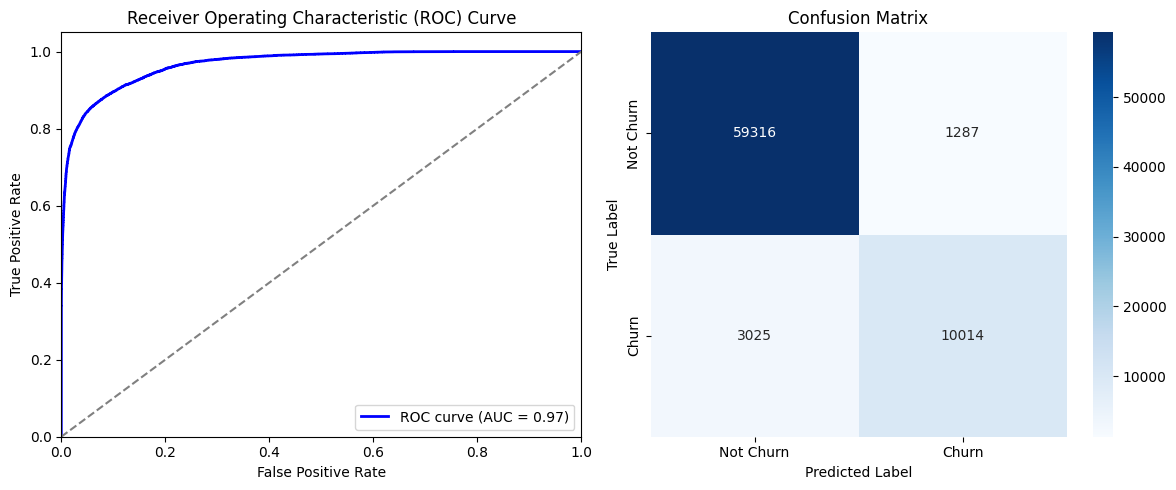

In [29]:

# ROC Curve 및 AUC 계산
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # 클래스 1의 확률값
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve Plot
ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax[1])
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()